# Example of Comparing All Implemented Outlier Detection Models
### Álvaro Montesino, March 3rd, 2021

This code is an adaptation of the PyOD example source code named "[compare_all_models.py](https://github.com/yzhao062/pyod/blob/master/examples/compare_all_models.py)", available in the [PyOD project repository](https://pyod.readthedocs.io/en/latest/). 

**[PyOD](https://github.com/yzhao062/pyod)** is a comprehensive **Python toolkit** to **identify outlying objects** in 
multivariate data with both unsupervised and supervised approaches.
The model covered in this example includes:

  1. Linear Models for Outlier Detection:
     1. **PCA: Principal Component Analysis** use the sum of
       weighted projected distances to the eigenvector hyperplane 
       as the outlier outlier scores)
     2. **MCD: Minimum Covariance Determinant** (use the mahalanobis distances 
       as the outlier scores)
     3. **OCSVM: One-Class Support Vector Machines**
     
  2. Proximity-Based Outlier Detection Models:
     1. **LOF: Local Outlier Factor**
     2. **CBLOF: Clustering-Based Local Outlier Factor**
     3. **kNN: k Nearest Neighbors** (use the distance to the kth nearest 
     neighbor as the outlier score)
     4. **Median kNN** Outlier Detection (use the median distance to k nearest 
     neighbors as the outlier score)
     5. **HBOS: Histogram-based Outlier Score**
     
  3. Probabilistic Models for Outlier Detection:
     1. **ABOD: Angle-Based Outlier Detection**
  
  4. Outlier Ensembles and Combination Frameworks
     1. **Isolation Forest**
     2. **Feature Bagging**
     3. **LSCP**
     



In [1]:
!pip install pyod
!pip install combo

from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Import all models
import pyod
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

     |████████████████████████████████| 102kB 4.4MB/s 
  Created wheel for pyod: filename=pyod-0.8.7-cp37-none-any.whl size=115979 sha256=cd6acba888232493adf4fdcef15a58e03ee3e7f62b234abeeb8a04e670259ede
  Stored in directory: /root/.cache/pip/wheels/b7/8a/c9/5fe3f32692ad445fe573cf5b953d7a0d55dc1f7c8e229ebda0
Successfully built pyod
  Created wheel for combo: filename=combo-0.1.2-cp37-none-any.whl size=42028 sha256=7f422aac396c66aae49f4ab975ff1330fdefabd876803cbab749f04b1775c94e
  Stored in directory: /root/.cache/pip/wheels/01/d9/bf/d1a371a5f0844cd8a53c04c14daa89974c93f429dda9dceb86
Successfully built combo


In [2]:
# First step is getting the authorization code by loggin into your Google account. Then, paste the authorization code and press Enter.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

In [25]:
# New to both ways of manipulating file paths, os.path and libpath libs, and will develop this, its libpath equivalent
from pathlib import Path
import os

# Loop recursively through directories, looking for relevant files type.
# DATA_ROOT_DIR = Path("C:/Users/alvar/OneDrive/Personal/Data")
DATA_ROOT_DIR = Path( "/content/drive/MyDrive/Data" )
PATH_TO_DATA_FILE = DATA_ROOT_DIR / "Short Term Datasets" / "COVID Datasets" / "LockDown_Tracking.csv"

#! ls -la "$DATA_ROOT_DIR"
#! ls -la "$PATH_TO_DATA_FILE"

if not (DATA_ROOT_DIR.exists() and PATH_TO_DATA_FILE.exists() ):
      raise TypeError( "Root data directory does not exist:'%s'" % DATA_ROOT_DIR )

# Certain files to be excluded from search because of the impact that their layout has on pandas'
# ability to read table contents
exclusionList = [ 
      'EDA_reports'
      'electricity-domestic-consumption-data.xls',
      'renewable-in-electricity-production-share.xls',
      'Data Documentation Sheet.xlsx',
      'Solar_Met_Daily_19980101_20210202_Harare.csv'
]
if PATH_TO_DATA_FILE.name in exclusionList:
        pass

df = pd.read_csv( os.fspath( PATH_TO_DATA_FILE ) )
df.head( 3 )


,Date Time Hour Beginning,Original Res Forecast before Lockdown,Actual Residual Demand,Deviation From Original Fc,Latest Official Residual Forecast,Alert Level 1,Alert Level 2,Alert Level 3,Alert Level 4,Alert Level 5,Zero Line
0,2020-03-23 00:00,21291.629,20930.40,361.229,NaN,0,0,0,0,0,0.0
1,2020-03-23 01:00,21086.863,20749.27,337.593,NaN,0,0,0,0,0,0.0
2,2020-03-23 02:00,21005.153,20536.27,468.883,NaN,0,0,0,0,0,0.0


In [26]:
# Pristine copy of the data
df.count()

Date Time Hour Beginning                 8976
Original Res Forecast before Lockdown    8904
Actual Residual Demand                   8208
Deviation From Original Fc               8976
Latest Official Residual Forecast         768
Alert Level 1                            8976
Alert Level 2                            8976
Alert Level 3                            8976
Alert Level 4                            8976
Alert Level 5                            8976
Zero Line                                8976
dtype: int64

In [7]:
df.isna( )

,Date Time Hour Beginning,Original Res Forecast before Lockdown,Actual Residual Demand,Deviation From Original Fc,Latest Official Residual Forecast,Alert Level 1,Alert Level 2,Alert Level 3,Alert Level 4,Alert Level 5,Zero Line
0,False,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
8971,False,True,True,False,False,False,False,False,False,False,False
8972,False,True,True,False,False,False,False,False,False,False,False
8973,False,True,True,False,False,False,False,False,False,False,False
8974,False,True,True,False,False,False,False,False,False,False,False


In [27]:
# We proceed to define which columns are of interest...

print( "List of column headings:\n", df.columns )
print( )
FEATURES_OF_INTEREST = [
      'Original Res Forecast before Lockdown',
      'Actual Residual Demand'
]

#  ... and then remove rows with NaNs under such columns of interest.   
relevantFeaturesWithNaNs = [ feature for feature in df.columns[ df.isna().any() ].tolist() if feature in FEATURES_OF_INTEREST ]
print( "Columns with NaNs among the features of interest:'%s'" % relevantFeaturesWithNaNs  )
df = df.dropna( subset= relevantFeaturesWithNaNs )

# Most likely will have to undo this change and instead, revert back to pandas Series but, for the time being 
# I'll just proceed sorting on the first feature, in ascending order.
df.sort_values( by=[ FEATURES_OF_INTEREST[ 0 ] ], inplace=True )
print( df.count( ) )
df

List of column headings:
 Index(['Date Time Hour Beginning', 'Original Res Forecast before Lockdown',
       'Actual Residual Demand', 'Deviation From Original Fc',
       'Latest Official Residual Forecast', 'Alert Level 1', 'Alert Level 2',
       'Alert Level 3', 'Alert Level 4', 'Alert Level 5', 'Zero Line'],
      dtype='object')

Columns with NaNs among the features of interest:'['Original Res Forecast before Lockdown', 'Actual Residual Demand']'
Date Time Hour Beginning                 8208
Original Res Forecast before Lockdown    8208
Actual Residual Demand                   8208
Deviation From Original Fc               8208
Latest Official Residual Forecast           0
Alert Level 1                            8208
Alert Level 2                            8208
Alert Level 3                            8208
Alert Level 4                            8208
Alert Level 5                            8208
Zero Line                                8208
dtype: int64


,Date Time Hour Beginning,Original Res Forecast before Lockdown,Actual Residual Demand,Deviation From Original Fc,Latest Official Residual Forecast,Alert Level 1,Alert Level 2,Alert Level 3,Alert Level 4,Alert Level 5,Zero Line
6843,2021-01-02 03:00,18605.968,17227.320,1378.648,NaN,0,0,100000,0,0,0.0
6842,2021-01-02 02:00,18612.673,17126.900,1485.773,NaN,0,0,100000,0,0,0.0
6841,2021-01-02 01:00,18666.132,17293.270,1372.862,NaN,0,0,100000,0,0,0.0
506,2020-04-13 02:00,18735.191,14671.890,4063.301,NaN,0,0,0,0,100000,0.0
507,2020-04-13 03:00,18801.631,14718.880,4082.751,NaN,0,0,0,0,100000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1554,2020-05-26 18:00,33349.017,29574.287,3774.730,NaN,0,0,0,100000,0,0.0
1578,2020-05-27 18:00,33528.576,30692.707,2835.869,NaN,0,0,0,100000,0,0.0
2586,2020-07-08 18:00,33542.360,31096.626,2445.734,NaN,0,0,100000,0,0,0.0
2874,2020-07-20 18:00,33543.674,31874.759,1668.915,NaN,0,0,100000,0,0,0.0


In [54]:
# Define the number of inliers and outliers
n_samples = 200
n_samples = min( df[ FEATURES_OF_INTEREST[ 0 ] ].count(), df[ FEATURES_OF_INTEREST[ 1 ] ].count() )

outliers_fraction = 0.20

clusters_separation = [0]

# Compare given detectors under given settings
# We initialize two matrices for the range of potential values the data
MAX_X = 7
MAX_Y = 7
MAX_X = df[ FEATURES_OF_INTEREST[ 0 ] ].max()*1.05
MAX_Y = df[ FEATURES_OF_INTEREST[ 1 ] ].max()*1.05
MIN_X = df[ FEATURES_OF_INTEREST[ 0 ] ].min()*0.95
MIN_Y = df[ FEATURES_OF_INTEREST[ 1 ] ].min()*0.95

xx, yy = np.meshgrid( np.linspace( MIN_X, MAX_X, 100 ), np.linspace( MIN_Y, MAX_Y, 100 ) )
n_inliers = int( (1. - outliers_fraction) * n_samples )
n_outliers = int( outliers_fraction * n_samples )

# It seems as if we are using a vector to define which ranges are considered inliers vs. which other range is considered an outlier
# By default, no outliers.
ground_truth = np.zeros(n_samples, dtype=int)
# ...but anything found in the final (topmost) range will from now on be considered an outlier.
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [56]:
print( "#Inlier samples ( %d ) + #Outlier samples ( %d ) = %d" % ( n_inliers, n_outliers, n_inliers+n_outliers ) ) 
print( "# Number of samples:", n_samples ) 
print( "\n" )

print( "Axis markings for the 'x' axis:", xx )
print( "Axis markings for the 'y' axis:", yy )

#Inlier samples ( 6566 ) + #Outlier samples ( 1641 ) = 8207
# Number of samples: 8208


Axis markings for the 'x' axis: [[17675.6696     17855.16023737 18034.65087475 ... 35086.26142525
  35265.75206263 35445.2427    ]
 [17675.6696     17855.16023737 18034.65087475 ... 35086.26142525
  35265.75206263 35445.2427    ]
 [17675.6696     17855.16023737 18034.65087475 ... 35086.26142525
  35265.75206263 35445.2427    ]
 ...
 [17675.6696     17855.16023737 18034.65087475 ... 35086.26142525
  35265.75206263 35445.2427    ]
 [17675.6696     17855.16023737 18034.65087475 ... 35086.26142525
  35265.75206263 35445.2427    ]
 [17675.6696     17855.16023737 18034.65087475 ... 35086.26142525
  35265.75206263 35445.2427    ]]
Axis markings for the 'y' axis: [[13108.043      13108.043      13108.043      ... 13108.043
  13108.043      13108.043     ]
 [13323.0456404  13323.0456404  13323.0456404  ... 13323.0456404
  13323.0456404  13323.0456404 ]
 [13538.04828081 13538.04828081 13538.04828081 ... 13538

In [57]:
# Show the statistics of the data
#print('Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(shape=ground_truth.shape))
print('Ground truth shape is {shape}.\n'.format(shape=ground_truth.shape))
print( ground_truth )
print( n_samples )

Ground truth shape is (8208,).

[0 0 0 ... 1 1 1]
8208


In [58]:
random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}

In [59]:
# Show all detectors
for i, clf in enumerate( classifiers.keys() ):
    print('Model', i + 1, clf)

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Feature Bagging
Model 4 Histogram-base Outlier Detection (HBOS)
Model 5 Isolation Forest
Model 6 K Nearest Neighbors (KNN)
Model 7 Average KNN
Model 8 Local Outlier Factor (LOF)
Model 9 Minimum Covariance Determinant (MCD)
Model 10 One-class SVM (OCSVM)
Model 11 Principal Component Analysis (PCA)
Model 12 Locally Selective Combination (LSCP)


Features of interest: 'Original Res Forecast before Lockdown', 'Actual Residual Demand'
Size of the matrix of samples: 8208, 2
[[18605.968 17227.32 ]
 [18612.673 17126.9  ]
 [18666.132 17293.27 ]
 ...
 [33542.36  31096.626]
 [33543.674 31874.759]
 [33757.374 30214.9  ]]
1 fitting Angle-based Outlier Detector (ABOD)
2 fitting Cluster-based Local Outlier Factor (CBLOF)
3 fitting Feature Bagging
4 fitting Histogram-base Outlier Detection (HBOS)
5 fitting Isolation Forest
6 fitting K Nearest Neighbors (KNN)
7 fitting Average KNN
8 fitting Local Outlier Factor (LOF)
9 fitting Minimum Covariance Determinant (MCD)
11 fitting Principal Component Analysis (PCA)
12 fitting Locally Selective Combination (LSCP)


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


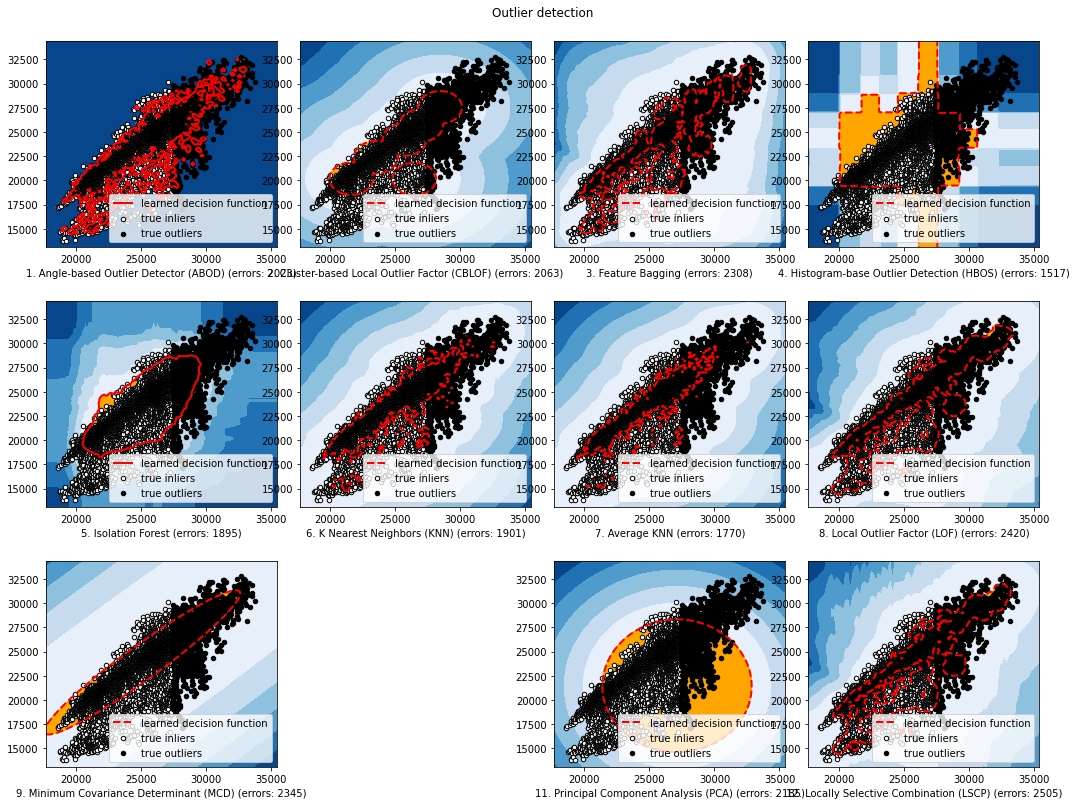

In [61]:
# Fit the models with the generated data and compare model performances

#REFERENCE_FOR_INLIERS = 0.3 *

for i, offset in enumerate( clusters_separation ):
    # np.random.seed(42)
    # print( "offset:", offset )
    # print( np.random.randn(n_inliers // 2, 2) - offset )
    # Data generation
    # We first create half of the inliers sample matrix, with as many rows containing values which are ranmdomly distributed  
    # around the mark,defined by REFERENCE_FOR_INLIERS, minus a certain offset. The offset is initially set to 0. Changing it requires hardcoding the change. 
    # X1 = REFERENCE_FOR_INLIERS * np.random.randn(n_inliers // 2, 2) - offset
    # We now create the second half of the inliers sample matrix, again with ranmdomly distributed values around the mark defined 
    # by REFERENCE_FOR_INLIERS+offset. The offset is still set to 0.
    # X2 = REFERENCE_FOR_INLIERS * np.random.randn(n_inliers // 2, 2) + offset
    # We combine both halfs into a single matrix
    # X = np.r_[X1, X2]
    # And now add the outlier rows, which are allowed to oscillate all the way to [-(MAX_X-1), +(MAX_X-1)], well beyond the previously chosen reference value of 0.3. 
    # X = np.r_[X, np.random.uniform(low=-(MAX_X-1), high=(MAX_X-1), size=(n_outliers, 2))]
    
    print( "Features of interest: '%s', '%s'" % ( FEATURES_OF_INTEREST[ 0 ], FEATURES_OF_INTEREST[ 1 ] ) )
    X = np.c_[ df[ FEATURES_OF_INTEREST[ 0 ] ], df[ FEATURES_OF_INTEREST[ 1 ] ] ]
    print( "Size of the matrix of samples: %d, %d" % ( X.shape[ 0 ], X.shape[ 1 ] ) )
    print( X )

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate( classifiers.items() ):
        # I am currently only familiar with the most frequent unsupervised and supervised classical ML algorithms. 
        # In particular, I am not familiar with deep learning algorithms, an issue that will interfere with my ability to debug
        # why some of algorithms may be crashing. I will therefore might need to temporarily skip using some of the classifiers, 
        # temporarely delaying debugging of their invocatiom, for the sake of letting the classifiers that follow be run, also.
        if ( clf_name in [ 'One-class SVM (OCSVM)' ] ):
             continue
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit( X )
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim( ( MIN_X, MAX_X) )
        subplot.set_ylim( ( MIN_Y, MAX_Y) )
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()